#  Building model

## Load data from process_data folder

In [4]:
import pandas as pd


# List of stock symbols
stock_symbols = ["AMZN", "AAPL", "NVDA", "MSFT", "GOOG", "META", "TSLA", "WMT", "JPM", "NFLX"]  # Extend this list as needed
stock = {}

# Dynamically construct file path and load the data for each stock symbol
for symbol in stock_symbols:
    file_path = f"../processed_data/data{symbol}.csv"  # Dynamically generate file path
    stock[symbol] = pd.read_csv(file_path)

df = {}
for i in range(len(stock_symbols)):
    df[stock_symbols[i]] = stock[stock_symbols[i]][['today', 'previous1', 'previous2', 'previous3', 'previous4', 'previous5', 'Volume',
                                                'ema50', 'ema21', 'ema14', 'ema5', 'rsi', 'macd', 'roc', 'atr', 'obv', 'cmf', 'emv', 'stoch', 'mfi', 'cci', 'trend']]



## Build logistic regression model

Processing AMZN...
AMZN Logistic Regression Accuracy: 0.70
AMZN Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.55      0.61       241
           1       0.70      0.81      0.75       315

    accuracy                           0.70       556
   macro avg       0.70      0.68      0.68       556
weighted avg       0.70      0.70      0.69       556

      Feature  Importance
17      stoch    1.533076
16        emv    1.491337
9        ema5    1.229062
19        cci    1.050622
12        roc    0.714093
3   previous4    0.695202
4   previous5    0.692237
2   previous3    0.671482
11       macd    0.618363
0   previous1    0.539169
10        rsi    0.507054
8       ema14    0.399492
1   previous2    0.364367
15        cmf    0.348073
5      Volume    0.332548
7       ema21    0.241608
18        mfi    0.089857
13        atr    0.081474
6       ema50    0.050743
14        obv    0.007990


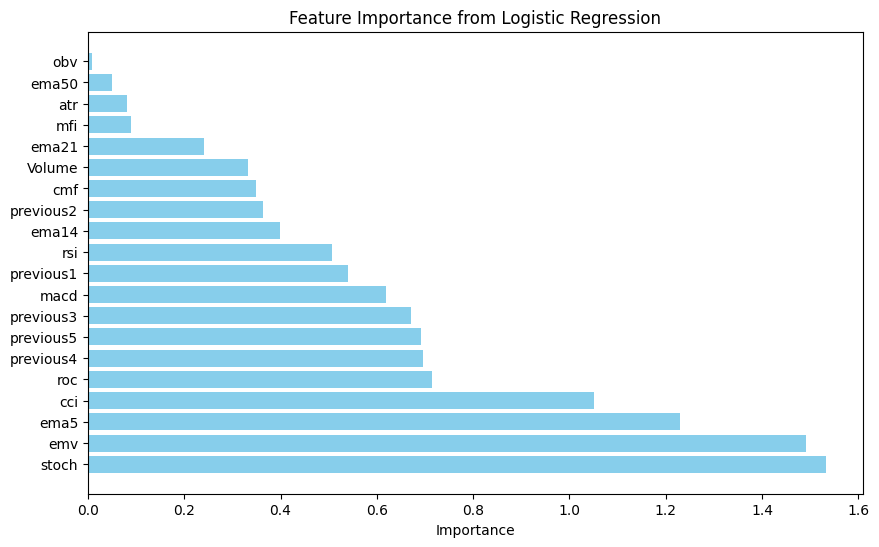

Processing AAPL...
AAPL Logistic Regression Accuracy: 0.68
AAPL Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.53      0.60       252
           1       0.67      0.81      0.73       304

    accuracy                           0.68       556
   macro avg       0.68      0.67      0.67       556
weighted avg       0.68      0.68      0.67       556

      Feature  Importance
17      stoch    1.576574
9        ema5    1.372405
19        cci    1.028024
2   previous3    0.815158
12        roc    0.707557
16        emv    0.684430
11       macd    0.670694
3   previous4    0.617431
5      Volume    0.510645
4   previous5    0.495509
1   previous2    0.360043
8       ema14    0.345511
10        rsi    0.316254
0   previous1    0.310150
13        atr    0.215420
15        cmf    0.163995
7       ema21    0.140750
14        obv    0.082894
18        mfi    0.071941
6       ema50    0.051797


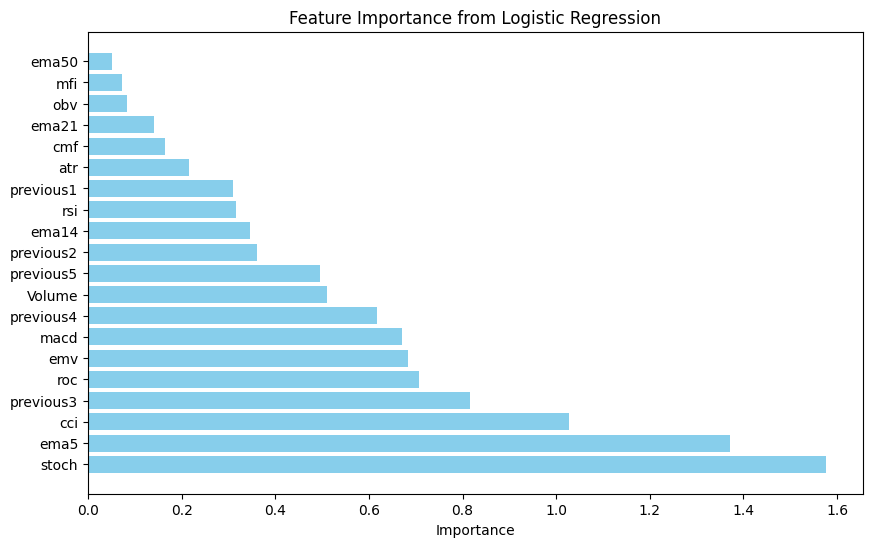

Processing NVDA...
NVDA Logistic Regression Accuracy: 0.67
NVDA Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.47      0.56       249
           1       0.66      0.82      0.73       307

    accuracy                           0.67       556
   macro avg       0.67      0.65      0.64       556
weighted avg       0.67      0.67      0.65       556

      Feature  Importance
9        ema5    1.465378
17      stoch    1.392008
19        cci    1.014526
12        roc    0.805065
2   previous3    0.622108
3   previous4    0.604488
16        emv    0.584628
15        cmf    0.578005
4   previous5    0.459141
10        rsi    0.419482
8       ema14    0.354853
0   previous1    0.325240
11       macd    0.306253
1   previous2    0.230439
18        mfi    0.152941
7       ema21    0.120304
6       ema50    0.116557
5      Volume    0.097132
14        obv    0.062950
13        atr    0.045948


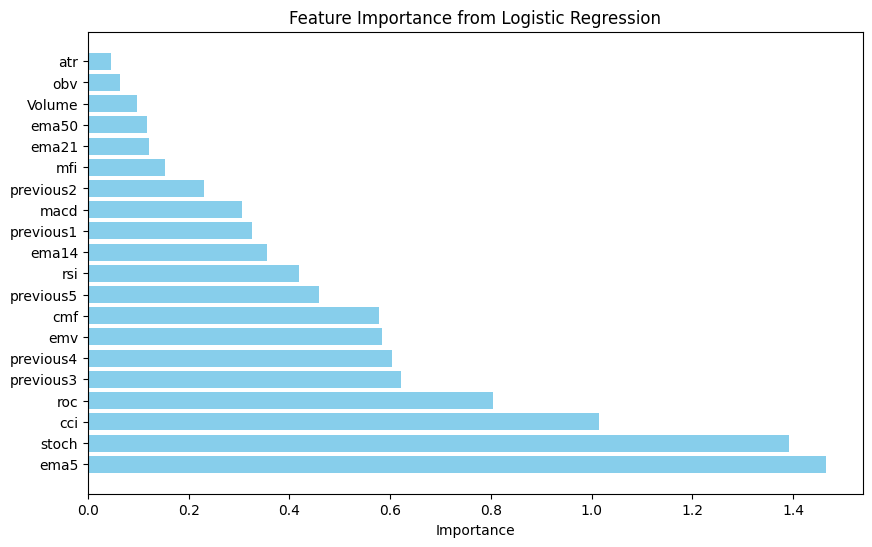

Processing MSFT...
MSFT Logistic Regression Accuracy: 0.70
MSFT Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.50      0.62       264
           1       0.66      0.88      0.76       292

    accuracy                           0.70       556
   macro avg       0.73      0.69      0.69       556
weighted avg       0.72      0.70      0.69       556

      Feature  Importance
17      stoch    1.567994
16        emv    1.559502
9        ema5    1.343009
19        cci    0.844739
11       macd    0.793015
12        roc    0.778253
3   previous4    0.645970
4   previous5    0.529917
2   previous3    0.515624
5      Volume    0.474342
15        cmf    0.469075
1   previous2    0.427397
8       ema14    0.362165
10        rsi    0.305702
13        atr    0.187347
7       ema21    0.186082
0   previous1    0.100609
18        mfi    0.087678
14        obv    0.079722
6       ema50    0.064082


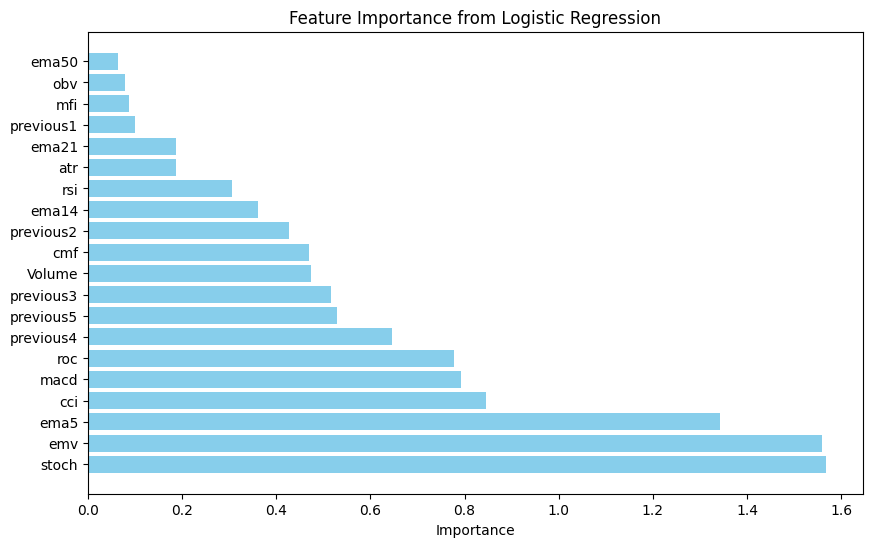

Processing GOOG...
GOOG Logistic Regression Accuracy: 0.69
GOOG Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.52      0.62       266
           1       0.66      0.85      0.74       290

    accuracy                           0.69       556
   macro avg       0.71      0.69      0.68       556
weighted avg       0.71      0.69      0.68       556

      Feature  Importance
17      stoch    1.513725
9        ema5    1.356789
16        emv    1.226407
19        cci    0.988441
2   previous3    0.826588
3   previous4    0.805290
12        roc    0.710670
4   previous5    0.664113
5      Volume    0.648349
10        rsi    0.570704
1   previous2    0.523906
11       macd    0.519595
8       ema14    0.432119
15        cmf    0.389835
0   previous1    0.380972
7       ema21    0.284920
6       ema50    0.252636
18        mfi    0.131598
13        atr    0.085153
14        obv    0.042447


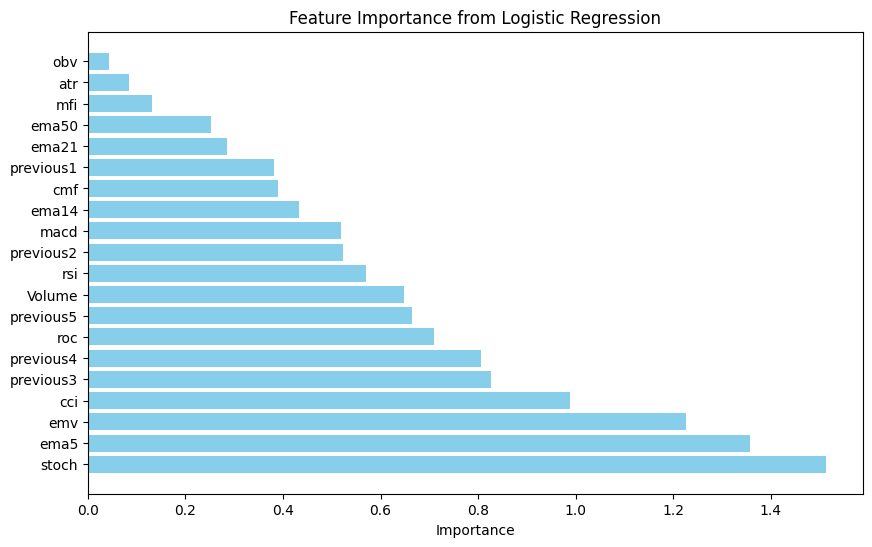

Processing META...
META Logistic Regression Accuracy: 0.69
META Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.52      0.62       261
           1       0.67      0.85      0.75       295

    accuracy                           0.69       556
   macro avg       0.71      0.68      0.68       556
weighted avg       0.71      0.69      0.68       556

      Feature  Importance
17      stoch    1.456090
19        cci    1.279553
16        emv    1.024708
9        ema5    0.976639
10        rsi    0.545575
12        roc    0.542445
4   previous5    0.504003
3   previous4    0.467485
11       macd    0.423541
0   previous1    0.418436
2   previous3    0.372697
15        cmf    0.343093
8       ema14    0.338853
1   previous2    0.293378
7       ema21    0.203200
5      Volume    0.132252
18        mfi    0.110554
13        atr    0.102597
14        obv    0.082278
6       ema50    0.053030


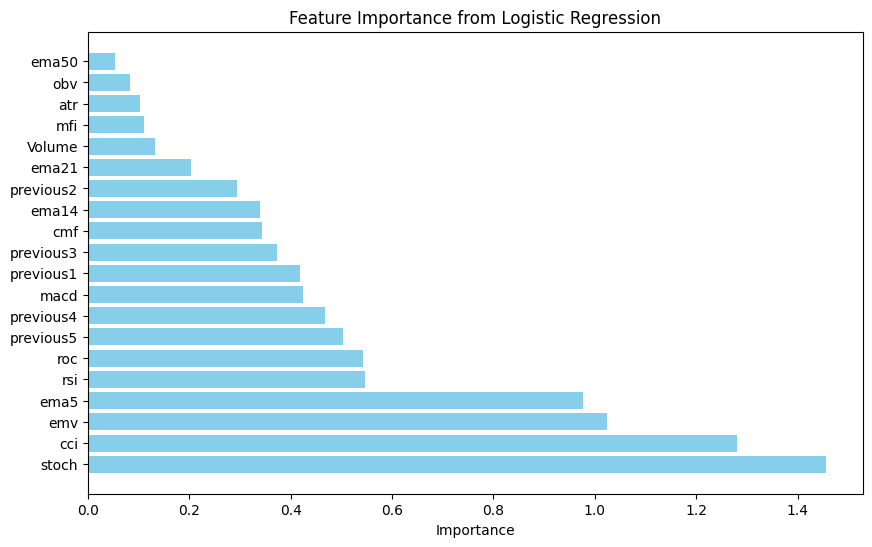

Processing TSLA...
TSLA Logistic Regression Accuracy: 0.70
TSLA Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.63      0.66       254
           1       0.71      0.75      0.73       302

    accuracy                           0.70       556
   macro avg       0.70      0.69      0.70       556
weighted avg       0.70      0.70      0.70       556

      Feature  Importance
17      stoch    1.654816
19        cci    1.251242
16        emv    1.151279
9        ema5    0.973992
2   previous3    0.771489
4   previous5    0.686597
3   previous4    0.686062
12        roc    0.685488
0   previous1    0.621478
11       macd    0.514292
15        cmf    0.433970
8       ema14    0.304211
1   previous2    0.282482
5      Volume    0.215863
7       ema21    0.167313
10        rsi    0.163420
18        mfi    0.117398
14        obv    0.056375
13        atr    0.055718
6       ema50    0.039104


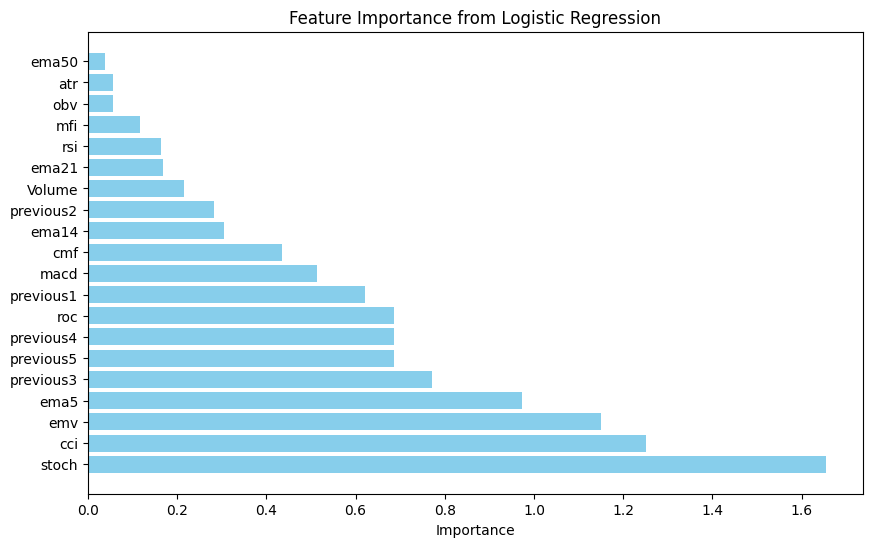

Processing WMT...
WMT Logistic Regression Accuracy: 0.68
WMT Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.53      0.60       260
           1       0.66      0.81      0.73       296

    accuracy                           0.68       556
   macro avg       0.69      0.67      0.67       556
weighted avg       0.68      0.68      0.67       556

      Feature  Importance
17      stoch    1.850451
16        emv    1.432565
19        cci    0.950208
9        ema5    0.921545
11       macd    0.796177
12        roc    0.553528
3   previous4    0.549645
2   previous3    0.484109
4   previous5    0.412296
15        cmf    0.409365
0   previous1    0.318495
1   previous2    0.283086
5      Volume    0.257635
8       ema14    0.244544
14        obv    0.186070
10        rsi    0.109243
6       ema50    0.099251
18        mfi    0.067142
7       ema21    0.066263
13        atr    0.003505


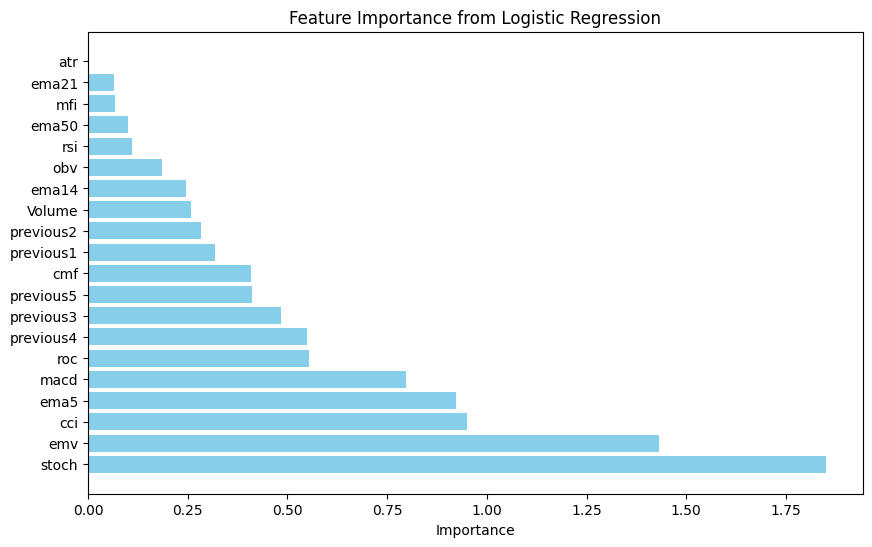

Processing JPM...
JPM Logistic Regression Accuracy: 0.68
JPM Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.52      0.59       242
           1       0.68      0.80      0.74       314

    accuracy                           0.68       556
   macro avg       0.67      0.66      0.66       556
weighted avg       0.68      0.68      0.67       556

      Feature  Importance
17      stoch    1.549336
19        cci    1.050852
9        ema5    1.035427
16        emv    0.805720
12        roc    0.698780
3   previous4    0.584786
11       macd    0.574532
15        cmf    0.467667
2   previous3    0.455563
10        rsi    0.441982
4   previous5    0.412859
8       ema14    0.321784
0   previous1    0.321235
6       ema50    0.300707
5      Volume    0.292695
7       ema21    0.250448
14        obv    0.234843
13        atr    0.183633
1   previous2    0.163537
18        mfi    0.040624


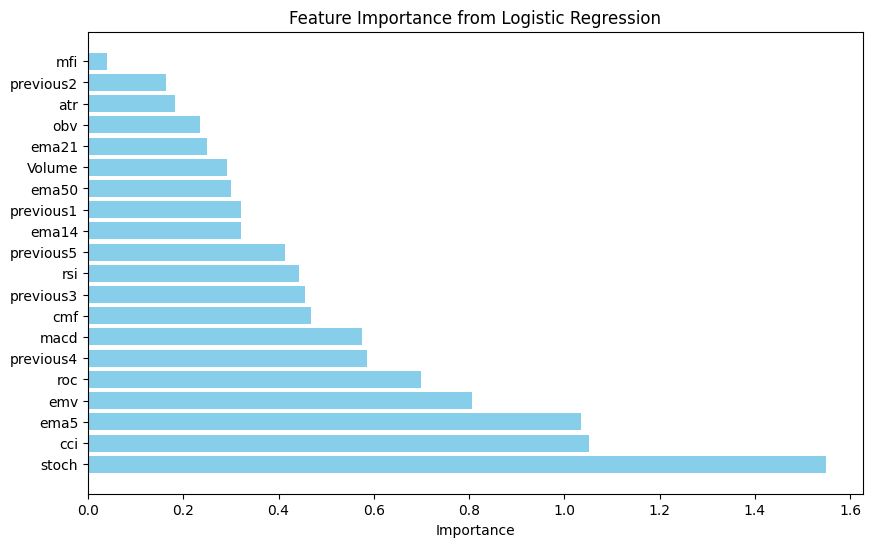

Processing NFLX...
NFLX Logistic Regression Accuracy: 0.65
NFLX Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.56      0.59       248
           1       0.67      0.72      0.69       307

    accuracy                           0.65       555
   macro avg       0.64      0.64      0.64       555
weighted avg       0.65      0.65      0.65       555

      Feature  Importance
17      stoch    1.554537
16        emv    1.268546
9        ema5    1.003735
19        cci    0.973996
12        roc    0.591186
11       macd    0.532111
4   previous5    0.530262
10        rsi    0.432577
3   previous4    0.406927
0   previous1    0.358728
2   previous3    0.322698
5      Volume    0.322556
15        cmf    0.281878
8       ema14    0.255879
18        mfi    0.227552
1   previous2    0.150400
13        atr    0.130878
7       ema21    0.110858
14        obv    0.100949
6       ema50    0.027475


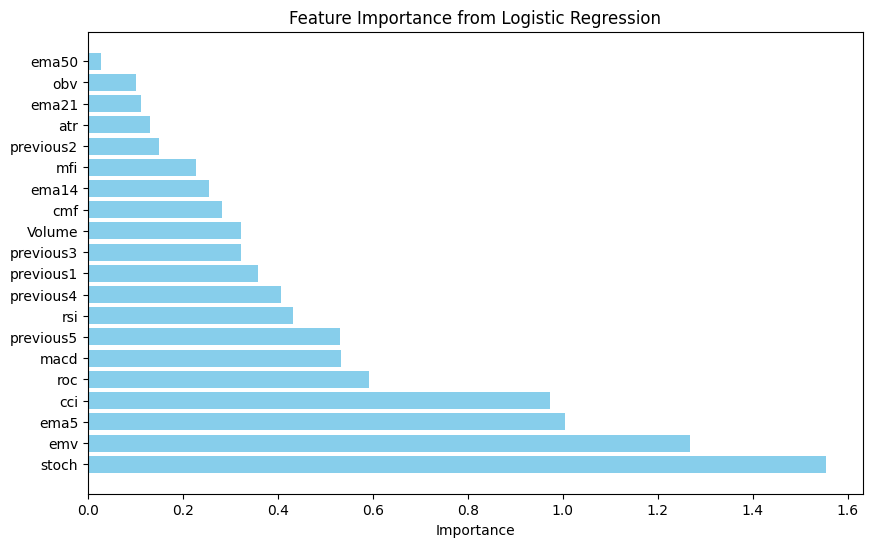

In [5]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from keras.src.models import Sequential
from keras.src.layers import LSTM, Dense, Dropout
from scipy.stats import loguniform

stock_symbols = ["AMZN", "AAPL", "NVDA", "MSFT", "GOOG", "META", "TSLA", "WMT", "JPM", "NFLX"]

for stock in stock_symbols:
    print(f"Processing {stock}...")

    # # LOGISTIC REGRESSION
    X = df[stock].loc[:, ~df[stock].columns.isin(['trend', 'today'])]
    y = df[stock]['trend']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

    scaler = MinMaxScaler()

    X_train_scaled = scaler.fit_transform(X_train.values)
    X_test_scaled = scaler.transform(X_test.values)

    lr = LogisticRegression(penalty='l2', C=0.1, random_state=42)

    lr.fit(X_train_scaled, y_train.values)

    predictions = lr.predict(X_test_scaled)
    accuracy = accuracy_score(y_test.values, predictions)
    print(f"{stock} Logistic Regression Accuracy: {accuracy:.2f}")
    classification_rep = classification_report(y_test.values, predictions)
    print(f"{stock} Logistic Regression Classification Report:\n", classification_rep)
    
    coefficients = lr.coef_[0]

    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Print feature importances
    print(feature_importance_df)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Feature Importance from Logistic Regression')
    plt.show()

    

   

## Random forest model

AMZN Random Forest Accuracy: 0.80
AMZN Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.78      0.78       255
           1       0.81      0.81      0.81       301

    accuracy                           0.80       556
   macro avg       0.80      0.80      0.80       556
weighted avg       0.80      0.80      0.80       556

   Feature  Importance
11     emv    0.322520
4     ema5    0.106118
12   stoch    0.087343
13     cci    0.061821
7      roc    0.055040
0   Volume    0.047164
5      rsi    0.045536
14     mfi    0.038073
10     cmf    0.036605
3    ema14    0.035546
6     macd    0.035131
2    ema21    0.033349
8      obv    0.033285
9      atr    0.032883
1    ema50    0.029587


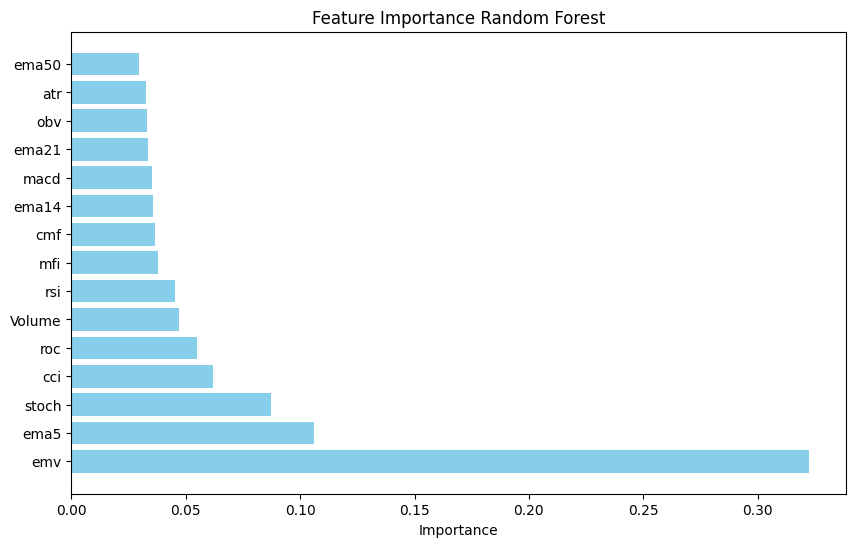

AAPL Random Forest Accuracy: 0.84
AAPL Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.82       248
           1       0.86      0.86      0.86       308

    accuracy                           0.84       556
   macro avg       0.84      0.84      0.84       556
weighted avg       0.84      0.84      0.84       556

   Feature  Importance
11     emv    0.274532
4     ema5    0.109676
12   stoch    0.089849
7      roc    0.068027
13     cci    0.065932
0   Volume    0.055000
5      rsi    0.047855
3    ema14    0.040418
14     mfi    0.039481
2    ema21    0.039462
6     macd    0.037284
8      obv    0.034188
1    ema50    0.033928
10     cmf    0.032344
9      atr    0.032025


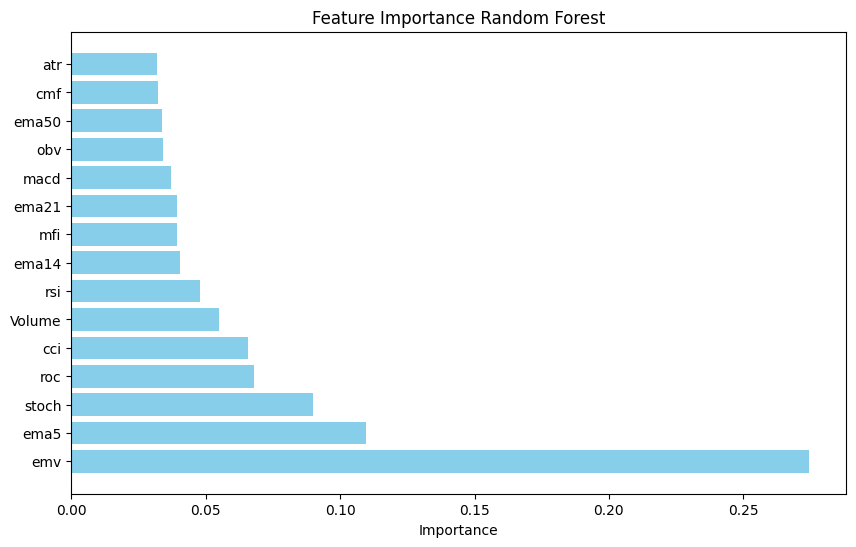

NVDA Random Forest Accuracy: 0.83
NVDA Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.82      0.80       234
           1       0.87      0.83      0.85       322

    accuracy                           0.83       556
   macro avg       0.82      0.83      0.82       556
weighted avg       0.83      0.83      0.83       556

   Feature  Importance
11     emv    0.283624
4     ema5    0.103181
12   stoch    0.084062
13     cci    0.071034
7      roc    0.063280
0   Volume    0.051349
5      rsi    0.046305
3    ema14    0.042535
10     cmf    0.038703
2    ema21    0.038212
6     macd    0.037936
14     mfi    0.037305
8      obv    0.035562
9      atr    0.034811
1    ema50    0.032102


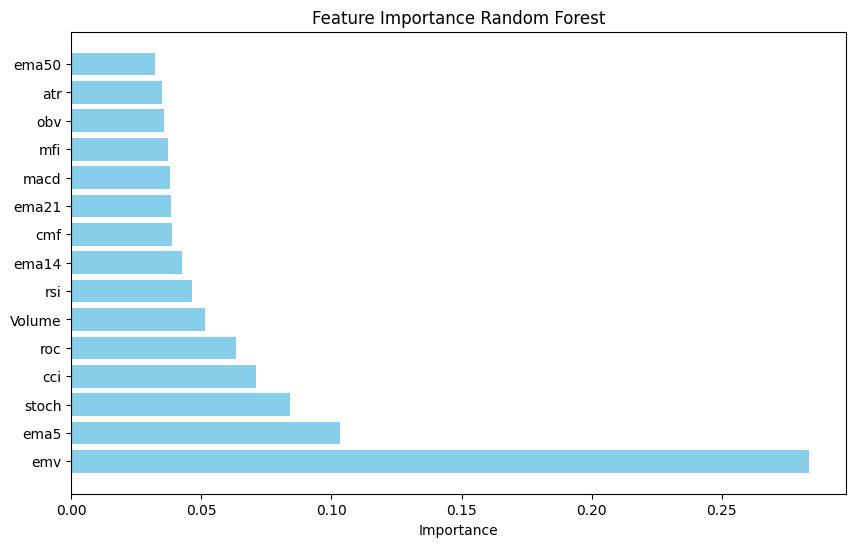

MSFT Random Forest Accuracy: 0.83
MSFT Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.81       252
           1       0.84      0.87      0.85       304

    accuracy                           0.83       556
   macro avg       0.83      0.83      0.83       556
weighted avg       0.83      0.83      0.83       556

   Feature  Importance
11     emv    0.291929
4     ema5    0.104361
12   stoch    0.086024
13     cci    0.064401
7      roc    0.058126
0   Volume    0.053590
5      rsi    0.041739
3    ema14    0.041597
6     macd    0.041539
10     cmf    0.040351
2    ema21    0.037098
14     mfi    0.036229
1    ema50    0.035312
9      atr    0.034126
8      obv    0.033578


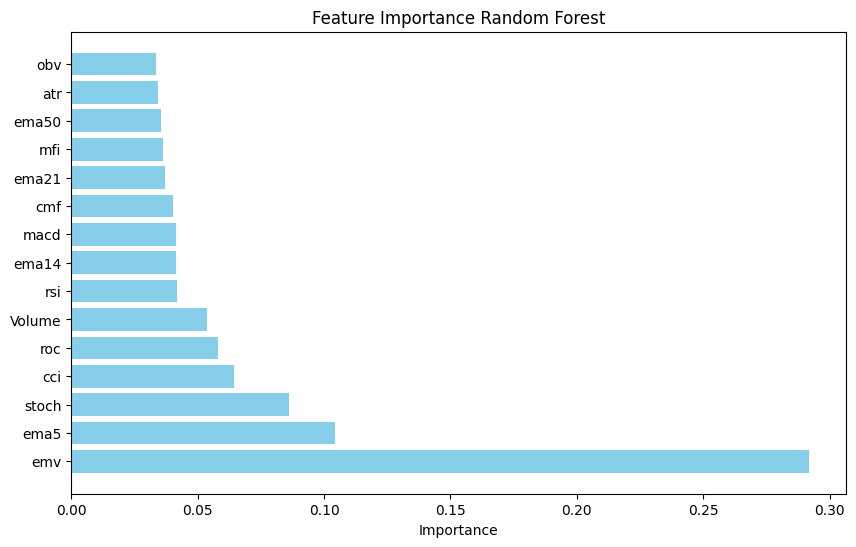

GOOG Random Forest Accuracy: 0.82
GOOG Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80       248
           1       0.83      0.85      0.84       308

    accuracy                           0.82       556
   macro avg       0.82      0.82      0.82       556
weighted avg       0.82      0.82      0.82       556

   Feature  Importance
11     emv    0.279431
4     ema5    0.112978
13     cci    0.074935
12   stoch    0.069872
7      roc    0.067076
0   Volume    0.051777
5      rsi    0.045299
14     mfi    0.044471
6     macd    0.040134
10     cmf    0.038860
3    ema14    0.037191
9      atr    0.035880
2    ema21    0.034782
8      obv    0.034140
1    ema50    0.033175


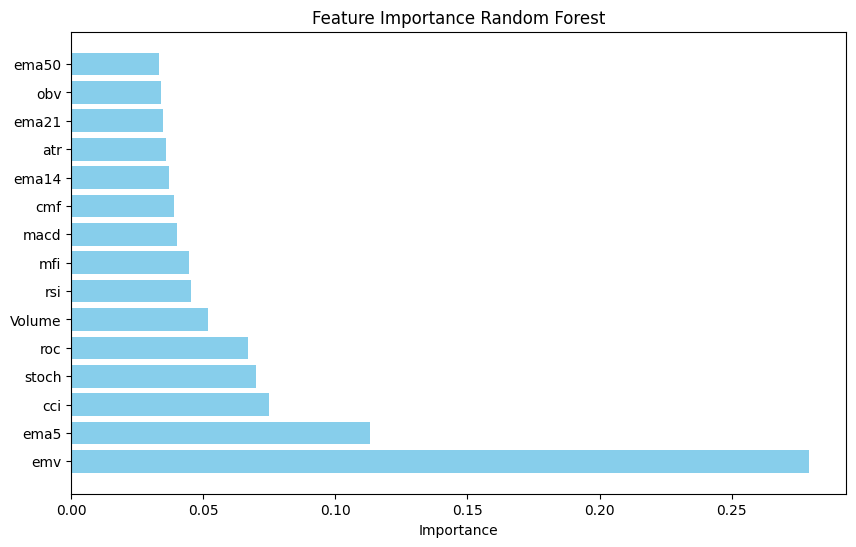

META Random Forest Accuracy: 0.83
META Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80       239
           1       0.85      0.85      0.85       317

    accuracy                           0.83       556
   macro avg       0.83      0.83      0.83       556
weighted avg       0.83      0.83      0.83       556

   Feature  Importance
11     emv    0.319793
4     ema5    0.104652
12   stoch    0.079774
13     cci    0.068413
7      roc    0.057050
5      rsi    0.046462
0   Volume    0.041989
10     cmf    0.039090
14     mfi    0.038579
2    ema21    0.035920
6     macd    0.035420
3    ema14    0.035205
9      atr    0.033810
8      obv    0.032978
1    ema50    0.030864


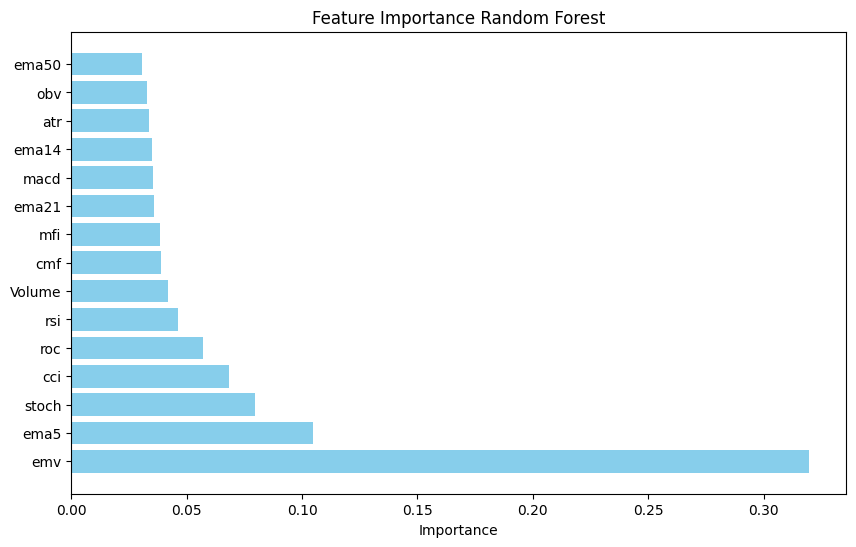

TSLA Random Forest Accuracy: 0.83
TSLA Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83       277
           1       0.84      0.82      0.83       279

    accuracy                           0.83       556
   macro avg       0.83      0.83      0.83       556
weighted avg       0.83      0.83      0.83       556

   Feature  Importance
11     emv    0.292296
4     ema5    0.107974
12   stoch    0.081730
7      roc    0.073818
13     cci    0.066707
0   Volume    0.048747
5      rsi    0.046865
10     cmf    0.038664
3    ema14    0.038298
6     macd    0.037949
14     mfi    0.037092
2    ema21    0.035010
8      obv    0.032510
1    ema50    0.032338
9      atr    0.030003


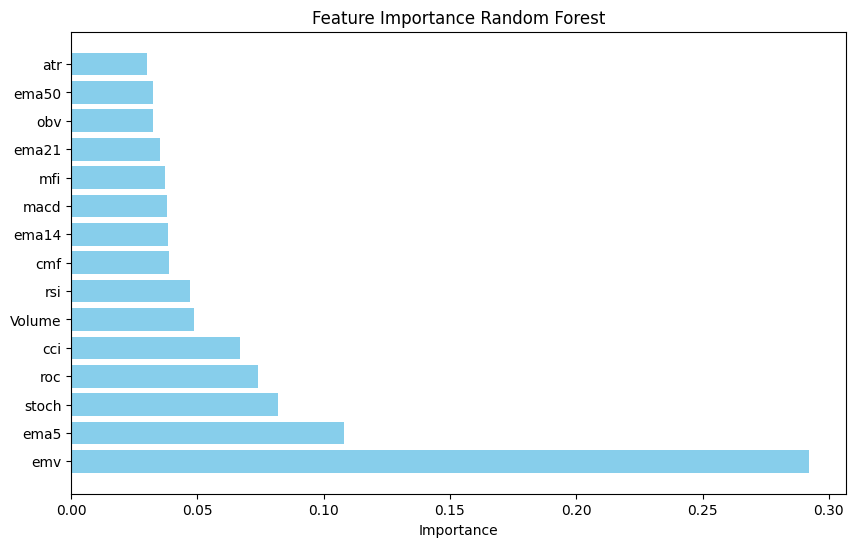

WMT Random Forest Accuracy: 0.83
WMT Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.77      0.78       231
           1       0.84      0.87      0.85       325

    accuracy                           0.83       556
   macro avg       0.82      0.82      0.82       556
weighted avg       0.82      0.83      0.82       556

   Feature  Importance
11     emv    0.268281
4     ema5    0.115243
12   stoch    0.093109
13     cci    0.063797
7      roc    0.059329
5      rsi    0.049518
0   Volume    0.045911
14     mfi    0.042354
6     macd    0.042033
3    ema14    0.041784
2    ema21    0.037494
8      obv    0.036664
10     cmf    0.036400
9      atr    0.034900
1    ema50    0.033183


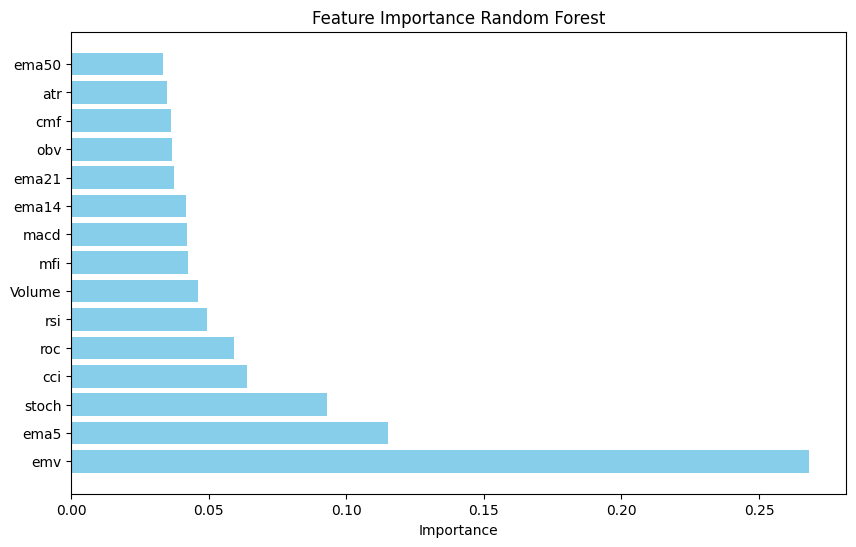

JPM Random Forest Accuracy: 0.84
JPM Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.77      0.79       228
           1       0.85      0.88      0.86       328

    accuracy                           0.84       556
   macro avg       0.83      0.83      0.83       556
weighted avg       0.84      0.84      0.84       556

   Feature  Importance
11     emv    0.294657
4     ema5    0.104849
12   stoch    0.080712
13     cci    0.067204
7      roc    0.060871
5      rsi    0.051208
0   Volume    0.049652
3    ema14    0.038833
14     mfi    0.038624
8      obv    0.037490
6     macd    0.036952
2    ema21    0.036346
10     cmf    0.035400
9      atr    0.034359
1    ema50    0.032843


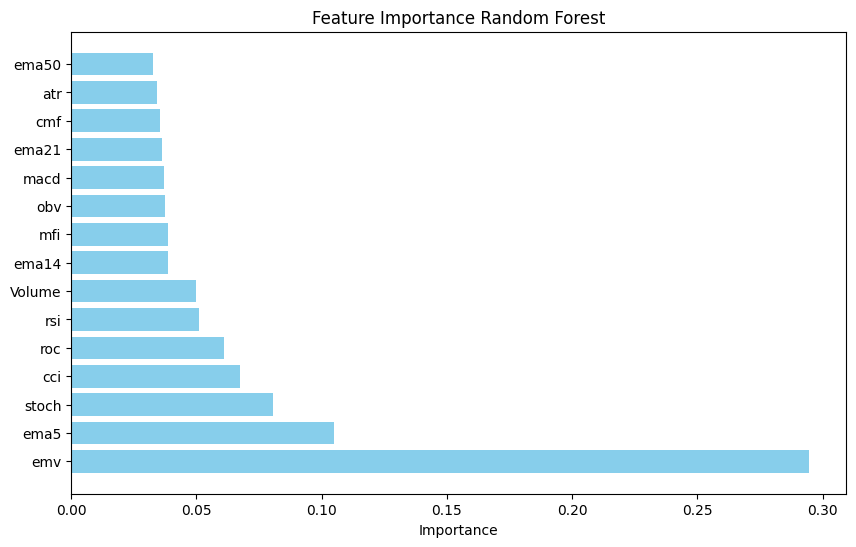

NFLX Random Forest Accuracy: 0.85
NFLX Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.83       248
           1       0.86      0.86      0.86       307

    accuracy                           0.85       555
   macro avg       0.84      0.84      0.84       555
weighted avg       0.84      0.85      0.84       555

   Feature  Importance
11     emv    0.275182
4     ema5    0.095293
13     cci    0.069914
12   stoch    0.064839
7      roc    0.063110
0   Volume    0.058093
14     mfi    0.047815
5      rsi    0.046141
6     macd    0.042576
3    ema14    0.042042
8      obv    0.041104
10     cmf    0.040208
2    ema21    0.040166
9      atr    0.040064
1    ema50    0.033454


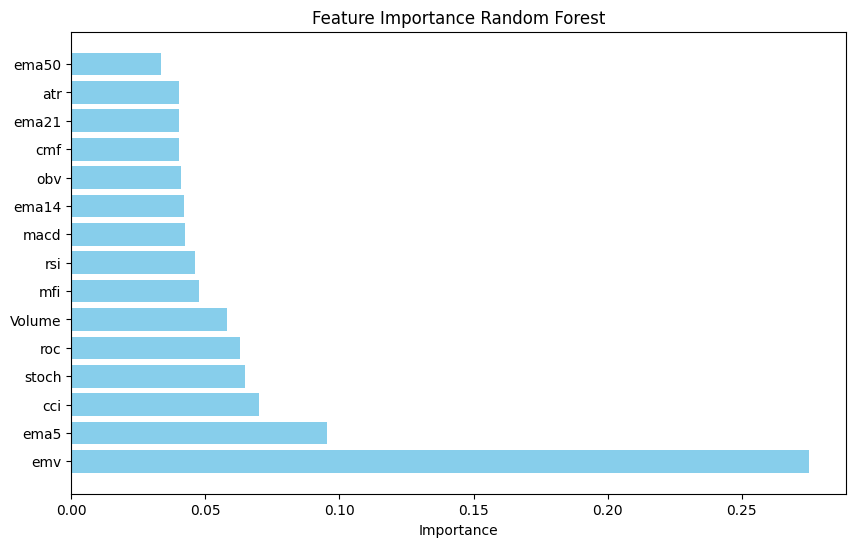

In [6]:
#RANDOM FOREST
for stock in stock_symbols:
    X = df[stock][['Volume', 'ema50', 'ema21',
                          'ema14', 'ema5', 'rsi',
                           'macd', 'roc', 'obv',
                            'atr', 'cmf', 'emv',
                             'stoch', 'cci', 'mfi']]
    y = df[stock]['trend']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

    rf = RandomForestClassifier(n_estimators=110, random_state=21)
    rf.fit(X_train.values, y_train.values)

    y_pred = rf.predict(X_test.values)
    accuracy = accuracy_score(y_test.values, y_pred)
    print(f"{stock} Random Forest Accuracy: {accuracy:.2f}")
    classification_rep = classification_report(y_test.values, y_pred)
    print(f"{stock} Random Forest Classification Report:\n", classification_rep)
    
    importances = rf.feature_importances_

    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    # Print feature importances
    print(feature_importance_df)
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Feature Importance Random Forest')
    plt.show()


# LSTM model

In [7]:
 # LSTM
for stock in stock_symbols:
    X = df[stock].loc[:, df[stock].columns != 'trend']
    y = df[stock]['trend']
    scale = MinMaxScaler(feature_range=(0,1))
    X_scaled = scale.fit_transform(X)

    timesteps = 10
    feature = X_scaled.shape[1]
    
    test_len = int(len(X_scaled)*0.25)
    train_len = X_scaled.shape[0] - test_len
    
    X_train = []
    y_train = []

    for i in range(timesteps, train_len):
        X_train.append(X_scaled[i-timesteps:i])
        y_train.append(y.values[i])

    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)

    X_test = []
    y_test = []
    for i in range(train_len-1, len(X_scaled)):
        X_test.append(X_scaled[i-timesteps: i])
        y_test.append(y.values[i])

    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test)

    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(timesteps, feature)))
    model.add(Dropout(0.1))
    model.add(LSTM(64))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=15, batch_size=8, validation_split=0.1, verbose=0)

    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{stock} LSTM Model Accuracy: {accuracy:.2f}")
    classification_rep = classification_report(y_test, y_pred)
    print(f"{stock} LSTM Classification Report:\n", classification_rep)


D:\githubhome\DataScienceProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
AMZN LSTM Model Accuracy: 0.59
AMZN LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.29      0.39       255
           1       0.58      0.85      0.69       301

    accuracy                           0.59       556
   macro avg       0.60      0.57      0.54       556
weighted avg       0.60      0.59      0.56       556



D:\githubhome\DataScienceProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
AAPL LSTM Model Accuracy: 0.62
AAPL LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.57      0.57       248
           1       0.65      0.65      0.65       308

    accuracy                           0.62       556
   macro avg       0.61      0.61      0.61       556
weighted avg       0.62      0.62      0.62       556



D:\githubhome\DataScienceProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
NVDA LSTM Model Accuracy: 0.62
NVDA LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.54      0.54       234
           1       0.67      0.67      0.67       322

    accuracy                           0.62       556
   macro avg       0.61      0.61      0.61       556
weighted avg       0.62      0.62      0.62       556



D:\githubhome\DataScienceProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
MSFT LSTM Model Accuracy: 0.60
MSFT LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.27      0.38       252
           1       0.59      0.88      0.71       304

    accuracy                           0.60       556
   macro avg       0.62      0.57      0.54       556
weighted avg       0.61      0.60      0.56       556



D:\githubhome\DataScienceProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
GOOG LSTM Model Accuracy: 0.63
GOOG LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.43      0.51       248
           1       0.63      0.79      0.70       308

    accuracy                           0.63       556
   macro avg       0.63      0.61      0.60       556
weighted avg       0.63      0.63      0.61       556



D:\githubhome\DataScienceProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
META LSTM Model Accuracy: 0.54
META LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.69      0.56       239
           1       0.64      0.42      0.51       317

    accuracy                           0.54       556
   macro avg       0.56      0.56      0.53       556
weighted avg       0.57      0.54      0.53       556



D:\githubhome\DataScienceProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
TSLA LSTM Model Accuracy: 0.62
TSLA LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.45      0.54       277
           1       0.59      0.78      0.67       279

    accuracy                           0.62       556
   macro avg       0.63      0.62      0.61       556
weighted avg       0.63      0.62      0.61       556



D:\githubhome\DataScienceProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
WMT LSTM Model Accuracy: 0.62
WMT LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.29      0.38       231
           1       0.63      0.85      0.72       325

    accuracy                           0.62       556
   macro avg       0.60      0.57      0.55       556
weighted avg       0.61      0.62      0.58       556



D:\githubhome\DataScienceProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
JPM LSTM Model Accuracy: 0.66
JPM LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.53      0.56       228
           1       0.69      0.75      0.72       328

    accuracy                           0.66       556
   macro avg       0.64      0.64      0.64       556
weighted avg       0.65      0.66      0.65       556



D:\githubhome\DataScienceProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
NFLX LSTM Model Accuracy: 0.57
NFLX LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.14      0.22       248
           1       0.57      0.92      0.70       307

    accuracy                           0.57       555
   macro avg       0.58      0.53      0.46       555
weighted avg       0.58      0.57      0.49       555

